In [1]:
import h3
import pandas as pd
import numpy as np

import shapely.geometry
from pyproj import Transformer
from pyproj import Geod
from shapely.ops import transform
from geopy.distance import geodesic

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Circle


In [2]:
# H3 cell areas by resolution (in m^2)
h3_areas = {res: h3.average_hexagon_area(res, unit="m^2") for res in range(16)}  # resolutions 0–15

# Function to get lowest H3 resolution that fits the area
def get_h3_resolution_for_area(area_m2):
    for res in sorted(h3_areas, reverse=True):
        if h3_areas[res] >= area_m2:
            return res
    return 5  # fallback to 5

In [17]:
def safe_latlng_to_cell(x):
    geor = x.get("georelated")
    if not geor:
        return None
    center = geor.get("center coordinates of affected area") if isinstance(geor, dict) else None
    if not center:
        return None
    lat = center.get("latitude") if isinstance(center, dict) else None
    lng = center.get("longitude") if isinstance(center, dict) else None
    area = geor.get("affected area in square km")  if isinstance(geor, dict) else None
    # Also check for None here:
    if lat is None or lng is None or area is None:
        return None
    try:
        return h3.latlng_to_cell(
            lat=float(lat),
            lng=float(lng),
            res=get_h3_resolution_for_area(float(area) / 7 * 1e6),
        )
    except Exception as e:
        return None

def get_cell_relation(pred_cell, target_cell) -> str:
    """
    Determines the relationship between two H3 cells.
    :param pred_cell: The predicted H3 cell.
    :param target_cell: The ground truth H3 cell.
    :return: A string indicating the relationship.
    """

    if pred_cell == target_cell:
        return "identical"

    # Get their resolutions
    pred_res = h3.get_resolution(pred_cell)
    gt_res = h3.get_resolution(target_cell)

    if pred_res == gt_res:
        return "disjoint_same_resolution"
    elif pred_res < gt_res:
        inferred_parent = h3.cell_to_parent(target_cell, pred_res)
        if pred_cell == inferred_parent:
            return "parent"
        else:
            if h3.are_neighbor_cells(pred_cell, inferred_parent):
                return "coarser_neighbor"
            return "disjoint_coarser_resolution"
    else:
        inferred_parent = h3.cell_to_parent(pred_cell, gt_res)
        if target_cell == inferred_parent:
            return "child"
        else:
            if h3.are_neighbor_cells(target_cell, inferred_parent):
                return "finer_neighbor"
            return "disjoint_finer_resolution"

In [4]:
def calculate_metrics(df, k=50):
    """
    Calculate various metrics for the georelated DataFrame.
    :param df: DataFrame containing georelated data.
    :param k: Accuracy threshold in km.
    :return: Dictionary of calculated metrics.
    """

    project = Transformer.from_crs('epsg:4326', 'epsg:6933', always_xy=True).transform

    # Prepare DataFrame columns for results (if not present)
    for col in ["error_distance", "pred_area_6933", "gt_area_6933", "intersection_area_6933"]:
        if col not in df.columns:
            df[col] = np.nan

    all_log_q_area = []
    all_log_q_distance = []
    all_delta_bearings = []

    # Calculate all metrics row-wise, store in DataFrame
    for index, row in df.iterrows():
        if row.get('pred_cell') is None or row.get('target_cell') is None:
            continue

        # Parse coordinates
        gt_lat, gt_lon = map(float, map(str.strip, row["target_center"].split(",")))
        gt_coordinates = (gt_lat, gt_lon)
        pred_center = row['georelated']['center coordinates of affected area']
        predicted_coordinates = (pred_center['latitude'], pred_center['longitude'])

        # Geodesic error in km
        error_distance = geodesic(gt_coordinates, predicted_coordinates).kilometers
        df.at[index, "error_distance"] = error_distance

        # H3 cell shapes
        pred_shape = h3.cells_to_h3shape([row['pred_cell']])
        target_shape = h3.cells_to_h3shape([row['target_cell']])
        pred_poly = shapely.geometry.shape(h3.h3shape_to_geo(pred_shape))
        target_poly = shapely.geometry.shape(h3.h3shape_to_geo(target_shape))

        # Project to equal-area CRS
        pred_poly_proj = transform(project, pred_poly)
        target_poly_proj = transform(project, target_poly)
        pred_area_m2 = pred_poly_proj.area
        gt_area_m2   = target_poly_proj.area

        df.at[index, "pred_area_6933"] = pred_area_m2
        df.at[index, "gt_area_6933"] = gt_area_m2

        # Intersection area
        intersection = pred_poly_proj.intersection(target_poly_proj)
        intersection_area = intersection.area
        df.at[index, "intersection_area_6933"] = intersection_area

        # Calculate proportion metrics for this row (if appropriate)
        try:
            log_q_area = np.log(pred_area_m2 / gt_area_m2)
            all_log_q_area.append(log_q_area)
            # if not nan
            if not np.isnan(row['distance_to_landmark']):
                log_q_distance = np.log(row['pred_distance'] / (row['distance_to_landmark'] +  1e-10))
                all_log_q_distance.append(log_q_distance)
            if not np.isnan(row['bearing']):
                delta_bearing = (row['forward_azimuth'] - row['bearing'] + 180) % 360 - 180
                all_delta_bearings.append(delta_bearing)
        except Exception:
            all_log_q_area.append(np.nan)

    ####### Aggregate Metrics ########

    # Remove NaNs
    all_error_distances = df["error_distance"].dropna().values
    all_log_q_area = np.array([x for x in all_log_q_area if not np.isnan(x)])
    all_log_q_distance = np.array([x for x in all_log_q_distance if not np.isnan(x)])
    all_delta_bearings = np.array([x for x in all_delta_bearings if not np.isnan(x)])

    # ACCURACY@k
    within_k = (all_error_distances <= k)
    accuracy_at_k = within_k.mean()
    strict_accuracy_at_k = np.sum(within_k) / len(df)

    # AUC function as before
    def calculate_auc(sorted_values):
        max_error = 20038  # Earth's circumference in km / 2
        size = len(sorted_values)
        if size <= 1:
            return 0.0
        h = 1  # step size
        log_max = np.log(max_error)
        auc = 0.5 * ((np.log(1 + sorted_values[0]) + np.log(1 + sorted_values[-1])) / log_max)
        for v in sorted_values[1:-1]:
            auc += np.log(1 + v) / log_max
        auc = auc * h / (size - 1)
        return auc

    sorted_error_distances = np.sort(all_error_distances)
    auc = calculate_auc(sorted_error_distances)

    # Mean/Median error
    mean_error_distance = np.mean(all_error_distances)
    median_error_distance = np.median(all_error_distances)

    # ζ Median Symmetric Accuracy
    zeta = 100 * (np.exp(np.median(np.abs(all_log_q_area))) - 1)

    # SSPB
    sspb = 100 * np.sign(np.median(all_log_q_area)) * (np.exp(np.abs(np.median(all_log_q_area))) - 1)

    valid = (
        (df['intersection_area_6933'] > 0) &
        (df['pred_area_6933'] > 0) &
        (df['gt_area_6933'] > 0)
    )
    average_precision = (df.loc[valid, 'intersection_area_6933'] / df.loc[valid, 'pred_area_6933']).mean()
    average_recall = (df.loc[valid, 'intersection_area_6933'] / df.loc[valid, 'gt_area_6933']).mean()
    average_f1 = 2 * average_precision * average_recall / (average_precision + average_recall)

    # bearing metrics
    mean_bearing_error = np.mean(all_delta_bearings)
    median_bearing_error = np.median(all_delta_bearings)
    mean_absolute_angular_error = np.mean(np.abs(all_delta_bearings))

    # distance metrics
    # ζ Median Symmetric Accuracy
    zeta_distance = 100 * (np.exp(np.median(np.abs(all_log_q_distance))) - 1)

    # SSPB
    sspb_distance = 100 * np.sign(np.median(all_log_q_distance)) * (np.exp(np.abs(np.median(all_log_q_distance))) - 1)


    # Return all metrics
    return {
        f"accuracy@{k}": accuracy_at_k,
        f"strict_accuracy@{k}": strict_accuracy_at_k,
        "auc": auc,
        "mean_error_distance": mean_error_distance,
        "median_error_distance": median_error_distance,
        "area_zeta": zeta,
        "area_sspb": sspb,
        "average_precision": average_precision,
        "average_recall": average_recall,
        "average_f1": average_f1,
        "mean_bearing_error": mean_bearing_error,
        "median_bearing_error": median_bearing_error,
        "mean_absolute_angular_error": mean_absolute_angular_error,
        "distance_zeta": zeta_distance,
        "distance_sspb": sspb_distance
    }

In [5]:
def plot_cell_relation_shares(df1, df2=None, label_df1="DataFrame 1", label_df2="DataFrame 2"):
    """
    Plot the shares of different cell relations in a bar chart.
    :param df1: First DataFrame containing cell relations.
    :param df2: Second DataFrame for comparison (optional).
    :param label_df1: Label for the first DataFrame.
    :param label_df2: Label for the second DataFrame.
    """
    # Define the cell relations
    labels = [
        'finer_neighbor', 'parent', 'child', 'coarser_neighbor', 'identical',
        'disjoint_same_resolution', 'disjoint_coarser_resolution', 'disjoint_finer_resolution'
    ]

    def get_shares(df):
        # Count occurrences of each cell relation
        cell_relation_counts = df['cell_relation'].value_counts()
        # Ensure order with predefined labels and compute shares
        cell_relation_shares = cell_relation_counts.reindex(labels) / cell_relation_counts.sum()
        return cell_relation_shares

    # Get shares for df1
    shares_df1 = get_shares(df1)

    # Sort shares for df1
    sorted_indices = shares_df1.sort_values(ascending=False).index

    # Reorder the labels and dataframe shares according to the sorted shares
    sorted_labels = [label for label in sorted_indices]
    sorted_shares_df1 = shares_df1[sorted_indices]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    if df2 is not None:
        # Get and reorder shares for df2 according to df1's sorted shares
        shares_df2 = get_shares(df2)
        sorted_shares_df2 = shares_df2[sorted_indices]

        # Bar width settings
        width = 0.35
        x = range(len(labels))  # indices for positioning bars

        # Plot both dataframes with different colors
        ax.bar(x, sorted_shares_df1, color='#7570b3', width=width, label=label_df1)
        ax.bar([p + width for p in x], sorted_shares_df2, color='#1b9e77', width=width, label=label_df2)

        # Set legend
        ax.legend()
    else:
        # Plot for single dataframe
        ax.bar(sorted_labels, sorted_shares_df1, color='#7570b3')

    # Set the title and labels
    ax.set_title('Cell Relations', fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('Share', fontsize=14)

    # Rotate x-axis labels for readability
    if df2 is not None:
        ax.set_xticks([p + width/2 for p in x])
    else:
        ax.set_xticks(range(len(sorted_labels)))
    ax.set_xticklabels(sorted_labels, rotation=45, ha='right', fontsize=12)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [6]:
def calc_azimuth_distance(row, geod=Geod(ellps="WGS84")):
    try:
        # Check if coordinates are missing (None or not a dict)
        center = row["georelated"].get("center coordinates of affected area")
        if center is None:
            return pd.Series({'forward_azimuth': None, 'pred_distance': None})
        fwd_azimuth, _, dist = geod.inv(
            row["landmark_longitude"],
            row["landmark_latitude"],
            center["longitude"],
            center["latitude"]
        )
        # Normalize azimuth to 0-360°
        fwd_azimuth = (fwd_azimuth + 360) % 360
        return pd.Series({'forward_azimuth': fwd_azimuth, 'pred_distance': dist})
    except Exception:
        # Catch possible missing keys or bad values
        return pd.Series({'forward_azimuth': None, 'pred_distance': None})

In [7]:
def plot_bearing_visualization(
    df,
    bearing_bin_size=15,
    distance_bin_size=0.1,
    upper_bound=0.9,
    lower_bound=0.1,
    focus_directions=None,
    plot_type='all_in_one'
):
    compass_dirs = {
        'north': (337.5, 22.5),
        'northeast': (22.5, 67.5),
        'east': (67.5, 112.5),
        'southeast': (112.5, 157.5),
        'south': (157.5, 202.5),
        'southwest': (202.5, 247.5),
        'west': (247.5, 292.5),
        'northwest': (292.5, 337.5)
    }

    dir_colors = {
        'north': '#b2182b',
        'northeast': '#f1b6da',
        'east': '#c51b7d',
        'southeast': '#9970ab',
        'south': '#2166ac',
        'southwest': '#80cdc1',
        'west': '#1a7837',
        'northwest': '#dfc27d'
    }

    def bearing_to_direction(bearing):
        for direction, (start, end) in compass_dirs.items():
            if start > end:
                if bearing >= start or bearing < end:
                    return direction
            else:
                if start <= bearing < end:
                    return direction
        return 'north'

    df['distance_ratio'] = df["pred_distance"] / df["distance_to_landmark"]
    lower_bound = df['distance_ratio'].quantile(lower_bound)
    upper_bound = df['distance_ratio'].quantile(upper_bound)
    df = df[(df['distance_ratio'] >= lower_bound) & (df['distance_ratio'] <= upper_bound)]

    df['bearing_bin'] = (df['forward_azimuth'] // bearing_bin_size * bearing_bin_size).astype(int)
    df['ratio_bin'] = (df['distance_ratio'] // distance_bin_size * distance_bin_size).round(2)
    df['gt_direction'] = df['bearing'].apply(bearing_to_direction)

    grouped = df.groupby(['bearing_bin', 'ratio_bin', 'gt_direction']).size().reset_index(name='count')
    grouped['theta'] = np.deg2rad(grouped['bearing_bin'])
    grouped['r'] = grouped['ratio_bin']
    inner_radius = 0.1
    grouped['r_plot'] = grouped['r'] + inner_radius
    grouped['bin_idx'] = grouped.groupby('bearing_bin').cumcount()
    grouped['theta_offset'] = grouped['bin_idx'] * (bearing_bin_size * np.pi / 180) / 10
    grouped['theta_final'] = grouped['theta'] + grouped['theta_offset'] - grouped['theta_offset'].mean()
    max_count = grouped['count'].max()
    min_width = 0.005
    grouped['width'] = np.maximum((grouped['count'] / max_count) * (bearing_bin_size * np.pi / 180) * 0.9, min_width)

    if plot_type == 'all_in_one':
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))

        # Draw ground truth reference circle with radius (1.0 + inner_radius)
        theta_line = np.linspace(0, 2*np.pi, 360)
        ax.plot(theta_line, np.full_like(theta_line, 1.0 + inner_radius), "k-", linewidth=1.5)

        for _, row in grouped.iterrows():
            color = dir_colors.get(row['gt_direction'], 'gray')
            ax.bar(
                x=row['theta_final'],
                height=row['r'],
                width=row['width'],
                bottom=inner_radius,
                color=color,
                alpha=1.0,
                edgecolor='none'
            )

        ax.set_theta_zero_location("N")
        ax.set_theta_direction("clockwise")
        r_max = grouped['r_plot'].max() + 0.1
        ax.set_ylim(0, r_max)

        tick_locations = [inner_radius + x for x in [0, 0.5, 1.0, 1.5, 2.0, 2.5]]
        ax.set_yticks(tick_locations)
        ax.set_yticklabels([f"{(t - inner_radius)*100:.0f}%" for t in tick_locations])
        ax.set_rlabel_position(25)

        for label in ax.get_yticklabels():
            if label.get_text() == "100%":
                label.set_fontweight("bold")

        ax.set_title("Model Performance by Bearing\n", fontsize=18, fontweight='bold')

        circle = Circle((0, 0), inner_radius, transform=ax.transData._b, facecolor='white', edgecolor='none', zorder=5)
        ax.add_artist(circle)

        ytick_lines = [
            Line2D([0], [0], color="gray", linewidth=1.5, label="0%: prediction on landmark"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="0 < r < 100%: prediction too short"),
            Line2D([0], [0], color="black", linewidth=1.5, label="100%: prediction == true distance"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="r > 100%: prediction too long")
        ]

        distance_ratio_legend = ax.legend(
            handles=ytick_lines,
            title="Trajector distance ratio",
            loc='lower center', bbox_to_anchor=(0.89, 0.9), ncol=1
        )
        distance_ratio_legend.get_title().set_ha('center')
        distance_ratio_legend.set_title("Trajector distance ratio", prop={'weight':'bold'})
        ax.add_artist(distance_ratio_legend)

        legend_patches = [Patch(color=color, label=dir.title()) for dir, color in dir_colors.items()]
        ax.legend(handles=legend_patches,
                  title="Ground truth direction",
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.11), ncol=4)
        ax.get_legend().get_title().set_fontweight('bold')
        ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
        ax.set_xticklabels(['North', 'East', 'South', 'West'], fontsize=12, ha='center')
        ax.spines['polar'].set_visible(False)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'subplots':
        if focus_directions is None:
            focus_directions = list(compass_dirs.keys())

        num_directions = len(focus_directions)
        fig, axes = plt.subplots(1, num_directions, subplot_kw={'projection': 'polar'}, figsize=(num_directions * 5, 5))
        plt.subplots_adjust(hspace=0.3, wspace=0.3)

        if num_directions == 1:
            axes = [axes]  # Fix the axes in case there's only one subplot

        for i, direction in enumerate(focus_directions):
            df_dir = df[df['gt_direction'] == direction]

            grouped_dir = df_dir.groupby(['bearing_bin', 'ratio_bin', 'gt_direction']).size().reset_index(name='count')
            grouped_dir['theta'] = np.deg2rad(grouped_dir['bearing_bin'])
            grouped_dir['r'] = grouped_dir['ratio_bin']
            grouped_dir['r_plot'] = grouped_dir['r'] + inner_radius

            grouped_dir['bin_idx'] = grouped_dir.groupby('bearing_bin').cumcount()
            grouped_dir['theta_offset'] = grouped_dir['bin_idx'] * (bearing_bin_size * np.pi / 180) / 10
            grouped_dir['theta_final'] = grouped_dir['theta'] + grouped_dir['theta_offset'] - grouped_dir['theta_offset'].mean()

            max_count_dir = grouped_dir['count'].max()
            grouped_dir['width'] = np.maximum((grouped_dir['count'] / max_count_dir) * (bearing_bin_size * np.pi / 180) * 0.9, min_width)

            ax = axes[i]
            theta_line = np.linspace(0, 2*np.pi, 360)
            ax.plot(theta_line, np.full_like(theta_line, 1.0 + inner_radius), "k-", linewidth=1.5)

            for _, row in grouped_dir.iterrows():
                color = dir_colors.get(row['gt_direction'], 'gray')
                ax.bar(
                    x=row['theta_final'],
                    height=row['r'],
                    width=row['width'],
                    bottom=inner_radius,
                    color=color,
                    alpha=1.0,
                    edgecolor='none'
                )

            ax.set_theta_zero_location("N")
            ax.set_theta_direction("clockwise")
            r_max_dir = grouped_dir['r_plot'].max() + 0.1
            ax.set_ylim(0, r_max_dir)

            tick_locations = [inner_radius + x for x in [0, 0.5, 1.0, 1.5, 2.0, 2.5]]
            ax.set_yticks(tick_locations)
            ax.set_yticklabels([f"{(t - inner_radius)*100:.0f}%" for t in tick_locations])
            ax.set_rlabel_position(25)

            for label in ax.get_yticklabels():
                label.set_fontweight("bold" if label.get_text() == "100%" else "normal")

            ax.set_title(f"{direction.title()}", fontsize=14, fontweight='bold')

            circle = Circle((0, 0), inner_radius, transform=ax.transData._b, facecolor='white', edgecolor='none', zorder=5)
            ax.add_artist(circle)

            ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
            ax.set_xticklabels(['North', 'East', 'South', 'West'], fontsize=10, ha='center')
            ax.spines['polar'].set_visible(False)

        # Display the distance ratio legend only once
        ytick_lines = [
            Line2D([0], [0], color="gray", linewidth=1.5, label="0%: prediction on landmark"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="0 < r < 100%: prediction too short"),
            Line2D([0], [0], color="black", linewidth=1.5, label="100%: prediction == true distance"),
            Line2D([0], [0], color="gray", linewidth=1.5, label="r > 100%: prediction too long")
        ]

        fig.legend(
            handles=ytick_lines,
            title="Trajector distance ratio",
            loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=int(num_directions),
            prop={'weight':'bold'}
        )

        plt.tight_layout()
        plt.show()

accuracy@10: 0.753
strict_accuracy@10: 0.669
auc: 0.187
mean_error_distance: 67.134
median_error_distance: 3.475
area_zeta: 599.600
area_sspb: -0.066
average_precision: 0.700
average_recall: 0.476
average_f1: 0.566
mean_bearing_error: 9.128
median_bearing_error: 1.733
mean_absolute_angular_error: 32.903
distance_zeta: 43.163
distance_sspb: 2.587


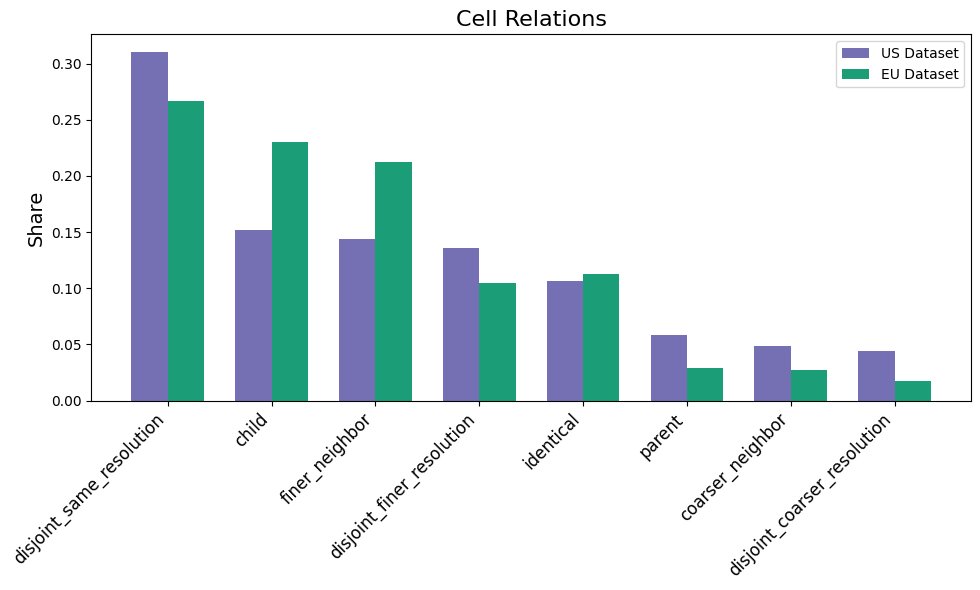

In [18]:
georelated_df_us = pd.read_json(r"/Users/kaimoltzen/academiccloudsync/Uni/Master/5_WS24_25-MA/geoparse-natural-disasters-with-llms/output/georelating/processed_20250517_cleaned_georelating_dataset_us_enriched_4.json", orient='records')

georelated_df_eu = pd.read_json(r"/Users/kaimoltzen/academiccloudsync/Uni/Master/5_WS24_25-MA/geoparse-natural-disasters-with-llms/output/georelating/processed_20250517_cleaned_georelating_dataset_eu_enriched_4.json", orient='records')

georelated_df_us['pred_cell'] = georelated_df_us.apply(safe_latlng_to_cell, axis=1)
georelated_df_us['pred_cell_area'] = georelated_df_us.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_us['cell_relation'] = georelated_df_us.apply(lambda x: get_cell_relation(x['pred_cell'], x['target_cell']) if x['pred_cell'] and x['target_cell'] else None, axis=1)
georelated_df_us[["forward_azimuth", "pred_distance"]] = georelated_df_us.apply(calc_azimuth_distance, axis=1)

georelated_df_eu['pred_cell'] = georelated_df_eu.apply(safe_latlng_to_cell, axis=1)
georelated_df_eu['pred_cell_area'] = georelated_df_eu.apply(lambda x: h3.cell_area(x['pred_cell'], unit="m^2") if x['pred_cell'] else None, axis=1)
georelated_df_eu['cell_relation'] = georelated_df_eu.apply(lambda x: get_cell_relation(x['pred_cell'], x['target_cell']) if x['pred_cell'] and x['target_cell'] else None, axis=1)

georelated_df_eu[["forward_azimuth", "pred_distance"]] = georelated_df_eu.apply(calc_azimuth_distance, axis=1)



metrics = calculate_metrics(georelated_df_us, k=10)
for key, value in metrics.items():
    print(f"{key}: {value:.3f}")


plot_cell_relation_shares(georelated_df_us, georelated_df_eu, label_df1="US Dataset", label_df2="EU Dataset")


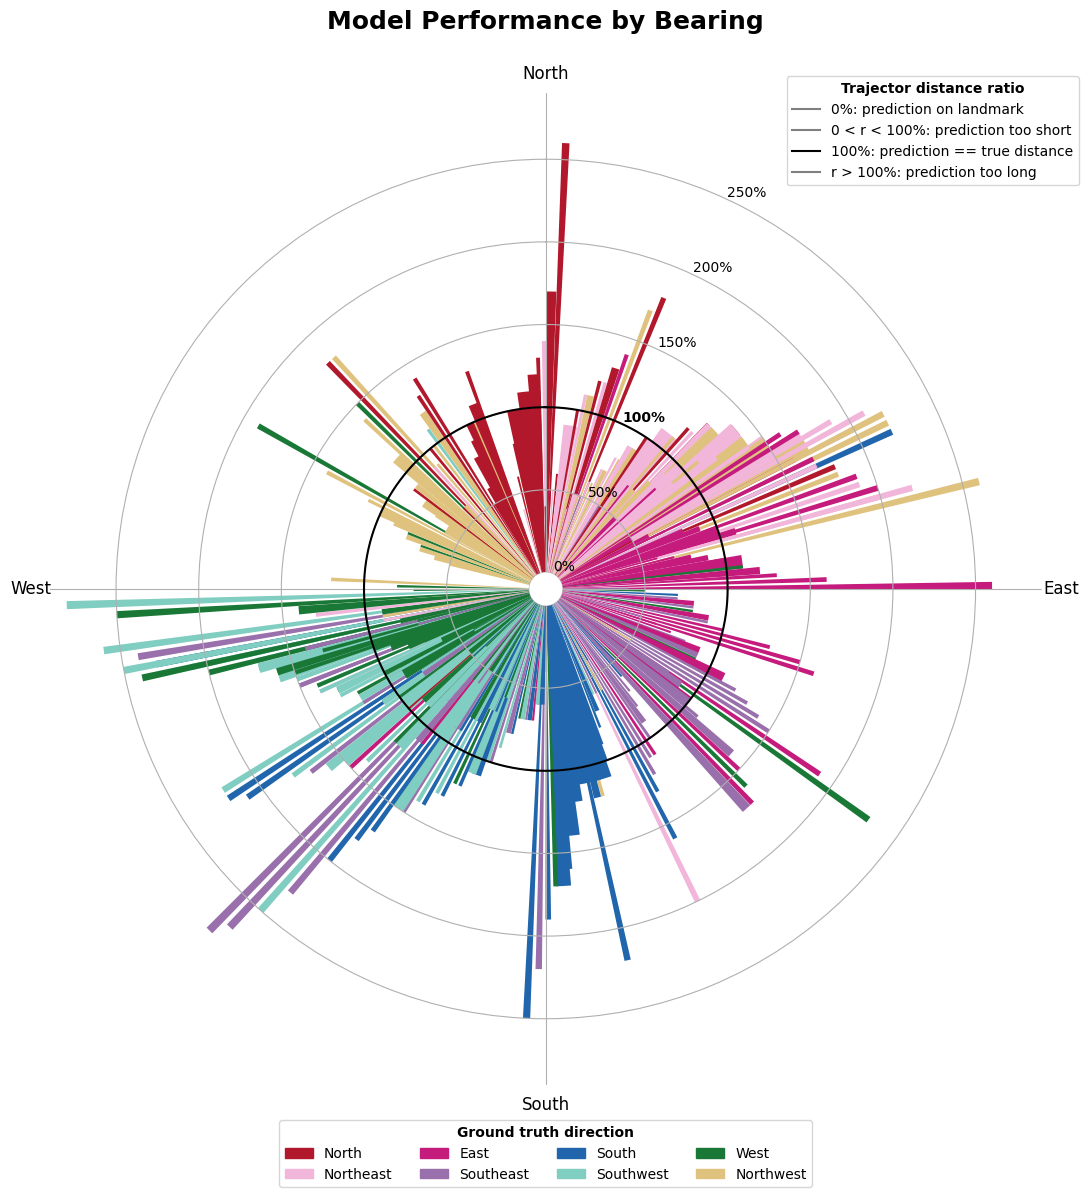

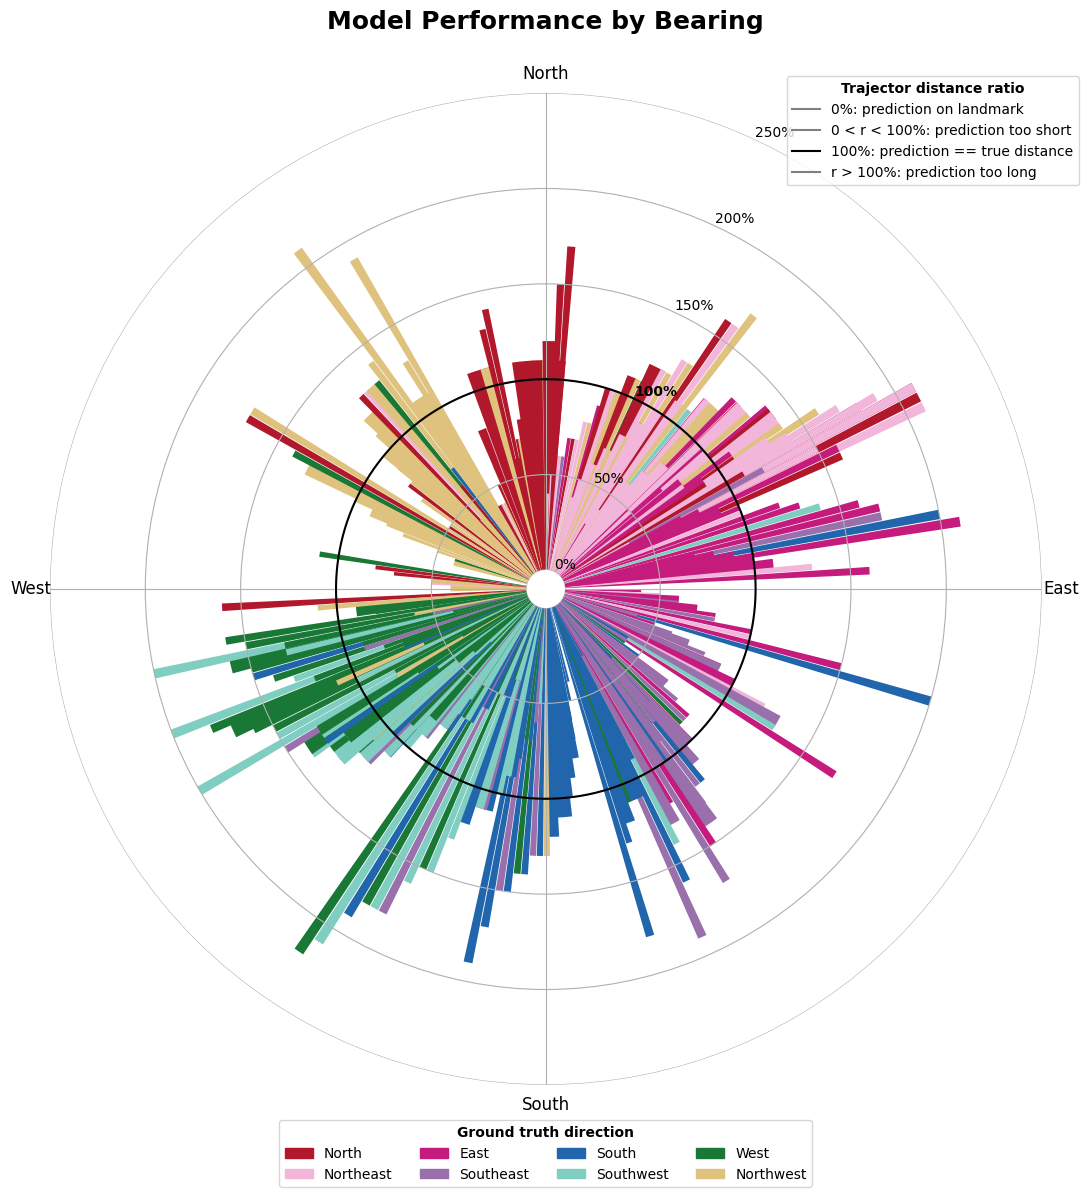

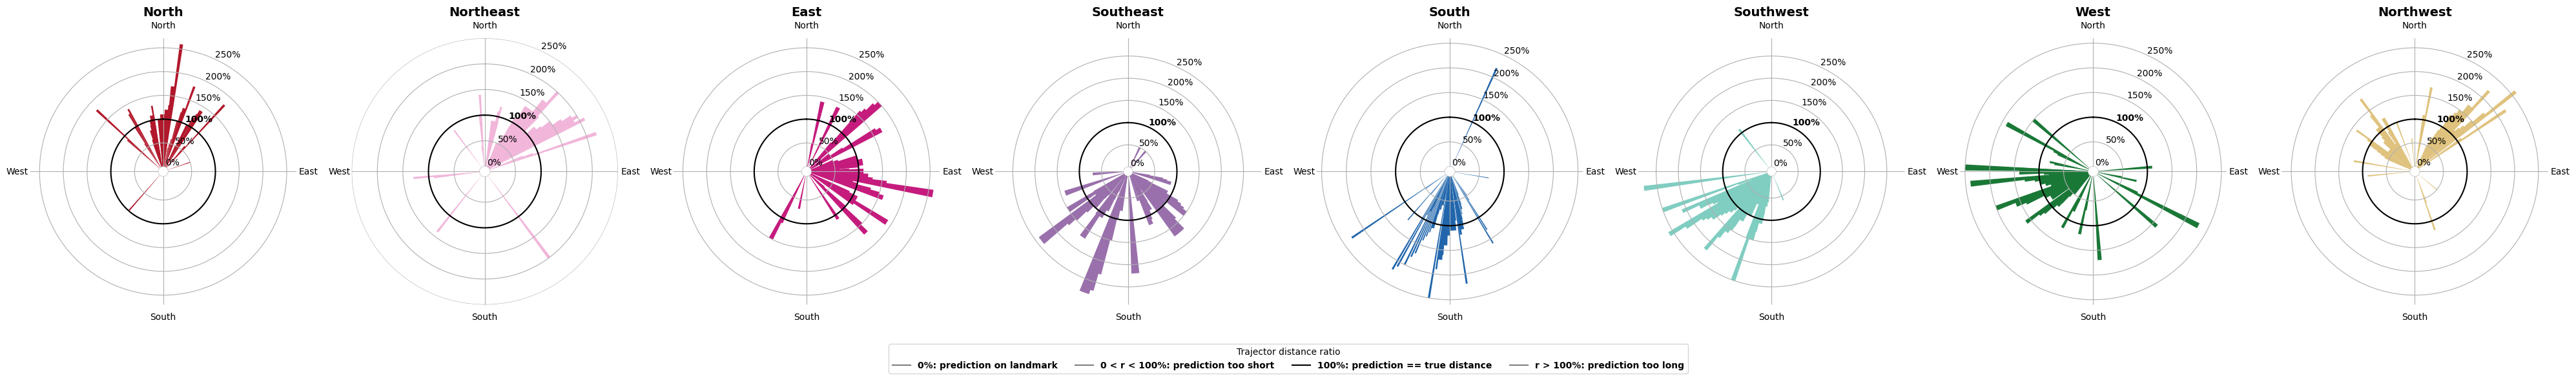

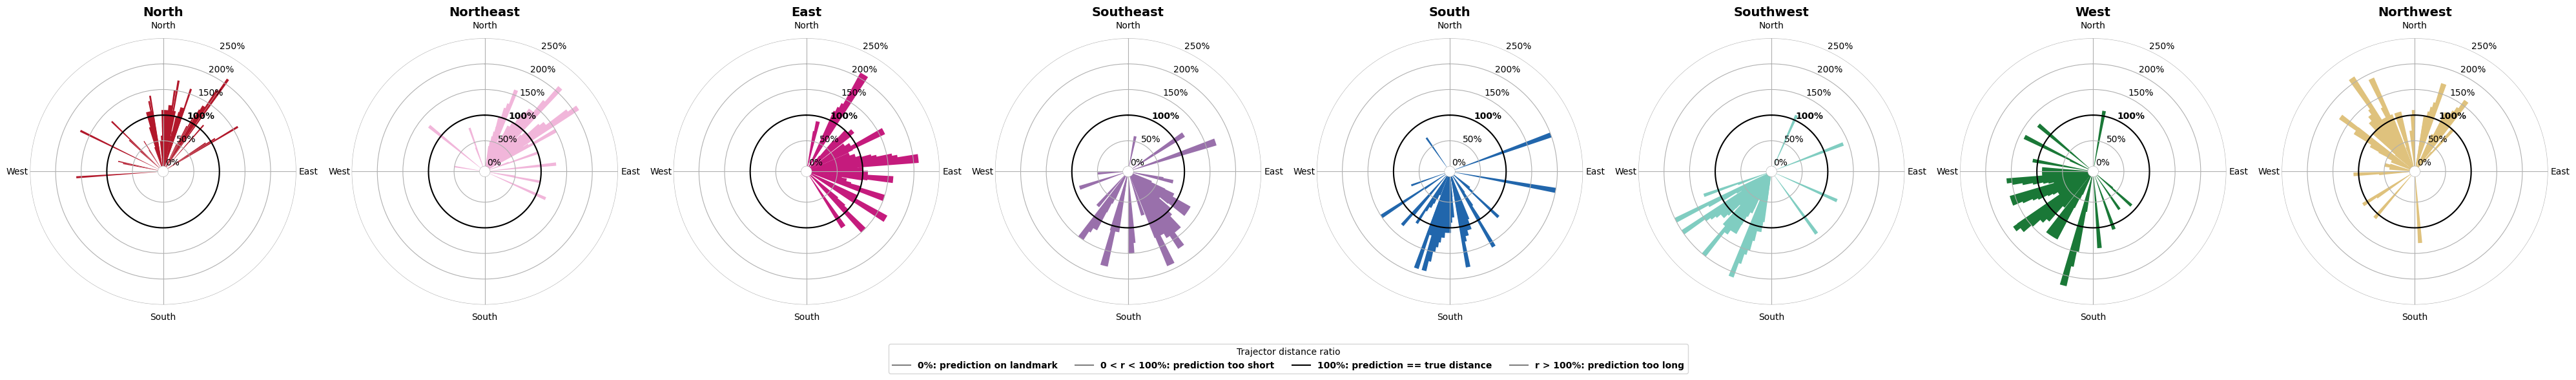

In [13]:
import warnings
warnings.filterwarnings("ignore")

plot_bearing_visualization(georelated_df_us, plot_type='all_in_one')
plot_bearing_visualization(georelated_df_eu, plot_type='all_in_one')

plot_bearing_visualization(georelated_df_us, plot_type='subplots')#, focus_directions=['northwest', 'northeast', 'southeast', 'southwest'])
plot_bearing_visualization(georelated_df_eu, plot_type='subplots')#, focus_directions=['northwest', 'northeast', 'southeast', 'southwest'])

In [15]:
between_df_us = georelated_df_us[georelated_df_us['geospatial_prep'] == 'between']
metrics_for_between = calculate_metrics(between_df_us, k=10)
for key, value in metrics_for_between.items():
    print(f"{key}: {value:.3f}")

accuracy@10: 0.652
strict_accuracy@10: 0.598
auc: 0.173
mean_error_distance: 59.883
median_error_distance: 3.958
area_zeta: 600.223
area_sspb: 600.220
average_precision: 0.269
average_recall: 0.772
average_f1: 0.399
mean_bearing_error: nan
median_bearing_error: nan
mean_absolute_angular_error: nan
distance_zeta: nan
distance_sspb: nan


In [16]:
near_df_us = georelated_df_us[georelated_df_us['geospatial_prep'] == 'near']
metrics_for_near = calculate_metrics(near_df_us, k=10)
for key, value in metrics_for_near.items():
    print(f"{key}: {value:.3f}")

accuracy@10: 0.674
strict_accuracy@10: 0.587
auc: 0.203
mean_error_distance: 31.549
median_error_distance: 4.079
area_zeta: 600.000
area_sspb: 599.712
average_precision: 0.234
average_recall: 0.716
average_f1: 0.352
mean_bearing_error: 6.338
median_bearing_error: 1.636
mean_absolute_angular_error: 50.353
distance_zeta: 119.788
distance_sspb: -80.232
